# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [4]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
import math as mt
import os

<div class="alert alert-block alert-warning">
<b>Comentario revisor</b> <a class="tocSkip"></a>


Recomiendo cargar la libreria math. De esta manera, puedes realizar redondeos con otros métodos. 
</div>

## Cargar datos

In [5]:
# Carga los archivos de datos en diferentes DataFrames
current_route = os.getcwd()
users_path = os.path.join(current_route, 'datasets', 'megaline_users.csv')
calls_path = os.path.join(current_route, 'datasets', 'megaline_calls.csv')
messages_path = os.path.join(current_route, 'datasets', 'megaline_messages.csv')
internet_path = os.path.join(current_route, 'datasets', 'megaline_internet.csv')
plans_path = os.path.join(current_route, 'datasets', 'megaline_plans.csv')

users = pd.read_csv(users_path)
calls = pd.read_csv(calls_path)
messages = pd.read_csv(messages_path)
internet = pd.read_csv(internet_path)
plans = pd.read_csv(plans_path)

## Preparar los datos

## Tarifas

In [6]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans.info()
print('El conteo de duplicados es:', plans.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes
El conteo de duplicados es: 0


In [7]:
# Imprime una muestra de los datos para las tarifas
print(plans.head(2))


   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


Este data frame está limpio, no requiere ningun trabajo para el entendimiento de los datos ni parecen presentar algun riesgo para la investigación futura.

## Corregir datos

In [8]:
plans.columns = ['messages_included','mb_per_month_included','minutes_included','usd_monthly_pay','usd_per_gb','usd_per_message','usd_per_minute' ,'plan']
print(plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute      plan  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


## Enriquecer los datos

In [9]:
plans['gb_per_month_included'] = plans['mb_per_month_included']/1024
print(plans)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute      plan  \
0               20          10             0.03            0.03      surf   
1               70           7             0.01            0.01  ultimate   

   gb_per_month_included  
0                   15.0  
1                   30.0  


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Muy buen trabajo!! Es correcto considerar que 1024 megabytes son 1 gigabytes.
    
</div>

## Usuarios/as

In [10]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users.info()
print('Count of duplicates: ', users.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
Count of duplicates:  0


In [11]:
# Imprime una muestra de datos para usuarios
print(users.head(10))


   user_id first_name  last_name  age                                    city  \
0     1000   Anamaria      Bauer   45   Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28         Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36    Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                           Tulsa, OK MSA   
4     1004    Leonila   Thompson   40         Seattle-Tacoma-Bellevue, WA MSA   
5     1005      Livia    Shields   31     Dallas-Fort Worth-Arlington, TX MSA   
6     1006     Jesusa   Bradford   73  San Francisco-Oakland-Berkeley, CA MSA   
7     1007    Eusebio      Welch   42           Grand Rapids-Kentwood, MI MSA   
8     1008      Emely    Hoffman   53       Orlando-Kissimmee-Sanford, FL MSA   
9     1009      Gerry     Little   19  San Jose-Sunnyvale-Santa Clara, CA MSA   

     reg_date      plan  churn_date  
0  2018-12-24  ultimate         NaN  
1  2018-08-13      surf         

A primera impresión no parece haber problemas con este data frame, solo es necesario cambiar el tipo de dato para las columnas 'reg_date' y 'chrun_date' a uno que lo identifique como lo que son: una fecha, y buscar una fecha infinita para remplazar los valores nulos de 'churn_date. No se encontraron duplicados.

En la columna 'churn_date' se encuentran valores NaN o NaT los cuales indican que el usuario mantuvo un plan activo cuando la base de datos fue extraída, esto quiere decir que eran clientes activos de la empresa.

### Corregir los datos

In [12]:
users['churn_date'].fillna('2200-12-31')
users.info()
print()
print(users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40       

### Enriquecer los datos

In [13]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format= '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users.info()
print()
print(users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    

## Llamadas

In [14]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [15]:
# Imprime una muestra de datos para las llamadas
print(calls.sample(n=10))
print('El conteo de duplicados es:', calls.duplicated().sum())

              id  user_id   call_date  duration
60817   1220_184     1220  2018-11-29      0.00
4092     1017_52     1017  2018-11-13      4.56
64390   1232_737     1232  2018-06-19      3.75
101282   1362_17     1362  2018-02-16      5.98
85562   1313_542     1313  2018-10-22     15.02
6285     1030_59     1030  2018-10-23      0.33
5283    1022_549     1022  2018-10-31      8.00
3316    1011_169     1011  2018-11-15      0.07
107410  1381_147     1381  2018-10-18      6.17
85120   1313_100     1313  2018-10-16     17.03


El conteo de duplicados es: 0


Para este data frame no tenemos nulls, sin embargo, hay que trabajar el tipo de dato de la columna 'call_date' y de acuerdo a la imlementación del conteo de minutos, hay que redondear la duración al entero mayor mas próximo. 

### Corregir los datos

In [16]:
calls['duration'] = np.ceil(calls['duration']).astype(int)
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()
print()
print(calls.sample(n=5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 3.7+ MB

             id  user_id  call_date  duration
47342  1171_373     1171 2018-11-30        19
33502  1126_188     1126 2018-10-16         9
32476  1122_314     1122 2018-11-12         4
27150    1102_0     1102 2018-12-15        27
61389   1222_36     1222 2018-11-14         0


### Enriquecer los datos

In [17]:
calls['month'] = calls['call_date'].dt.month
print(calls.head())

         id  user_id  call_date  duration  month
0   1000_93     1000 2018-12-27         9     12
1  1000_145     1000 2018-12-27        14     12
2  1000_247     1000 2018-12-27        15     12
3  1000_309     1000 2018-12-28         6     12
4  1000_380     1000 2018-12-30         5     12


## Mensajes

In [18]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [19]:
# Imprime una muestra de datos para los mensajes
print(messages.head(10))
print('El conteo de duplicados es:', messages.duplicated().sum())


         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26
5  1000_346     1000   2018-12-29
6  1000_386     1000   2018-12-30
7  1000_413     1000   2018-12-31
8  1000_502     1000   2018-12-27
9  1000_525     1000   2018-12-28
El conteo de duplicados es: 0


Solo es necesario ajustar el tipo de datos de la columna 'message_date'.

### Corregir los datos

In [20]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()
print()
print(messages.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


### Enriquecer los datos

In [21]:
messages['month'] = messages['message_date'].dt.month
print(messages.head())

         id  user_id message_date  month
0  1000_125     1000   2018-12-27     12
1  1000_160     1000   2018-12-31     12
2  1000_223     1000   2018-12-31     12
3  1000_251     1000   2018-12-27     12
4  1000_255     1000   2018-12-26     12


## Internet

In [22]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info()
print('El conteo de duplicados es:', internet.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
El conteo de duplicados es: 0


In [23]:
# Imprime una muestra de datos para el tráfico de internet
print(internet.head(10))


         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22
5    1001_0     1001   2018-08-24   284.68
6    1001_3     1001   2018-12-09   656.04
7    1001_4     1001   2018-11-04    16.97
8   1001_10     1001   2018-11-27   135.18
9   1001_15     1001   2018-12-13   761.92


Por ahora el único cambio necesario será cambiar el tipo de dato para la columna 'session_date' para identificarlo como una fecha. Posteriormente se trabajará sobre el entendimiento y la sumatoria de las condiciones establecidas por la empresa para poder agrupar y validar el consumo de cada cliente.

Posteriormente, de acuerdo a las condiciones se realizará el redondeo hacia arriba y la conversión de mb a gb para el correcto análisis de ingresos y costos extras aplicados a los clientes.

### Corregir los datos

In [24]:
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enriquecer los datos

In [25]:
internet['month'] = internet['session_date'].dt.month
print(internet.head())

         id  user_id session_date  mb_used  month
0   1000_13     1000   2018-12-29    89.86     12
1  1000_204     1000   2018-12-31     0.00     12
2  1000_379     1000   2018-12-28   660.40     12
3  1000_413     1000   2018-12-26   270.99     12
4  1000_442     1000   2018-12-27   880.22     12


<div class="alert alert-block alert-warning">
<b>Comentario revisor</b> <a class="tocSkip"></a>


Te recomiendo solamente comentar que cuando agrupemos los datos vamos a tener que redondear hacia arriba lo valores de la transformación de mbegabyter a gigabyte, para este ejercicio debemos hacer el redondeo superior dado que se cobra el costo extra en cuanto se pasa de los límites.Por lo que es necesario hacer la transformación de mb a gb y después hacer el redondeo.  
</div>

## Estudiar las condiciones de las tarifas

In [26]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
print('For calls we only have entire minutes withouth fractions.(Megaline round up the time by minutes).')
print()
print('For web sessions, Megaline round up monthly per gigabytes (1024 mb = 1 gb).')

For calls we only have entire minutes withouth fractions.(Megaline round up the time by minutes).

For web sessions, Megaline round up monthly per gigabytes (1024 mb = 1 gb).


In [27]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
user_monthly_call= calls.groupby(['user_id','month'])
user_qtty_calls = user_monthly_call['id'].count().reset_index(name='qtty_of_calls')
print(user_qtty_calls.head(10))


   user_id  month  qtty_of_calls
0     1000     12             16
1     1001      8             27
2     1001      9             49
3     1001     10             65
4     1001     11             64
5     1001     12             56
6     1002     10             11
7     1002     11             55
8     1002     12             47
9     1003     12            149


<div class="alert alert-block alert-warning">

<b>Comentario revisor</b> <a class="tocSkip"></a>

Si bien es correcta la forma de agrupar para sacar la duración de las llamadas por cada ususario, para proximas ocasiones puedes hacer uso de la siguiente forma:
    
    pivot_calls = calls.pivot_table(index=['user_id', 'month'],
                                values=['duration'],
                                aggfunc=['sum','count']).reset_index()

</div>

In [28]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
user_call_duration = user_monthly_call['duration'].sum().reset_index(name='total_minutes')
print(user_call_duration.head(10))


   user_id  month  total_minutes
0     1000     12            124
1     1001      8            182
2     1001      9            315
3     1001     10            393
4     1001     11            426
5     1001     12            412
6     1002     10             59
7     1002     11            386
8     1002     12            384
9     1003     12           1104


In [29]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
qtty_mesages_monthly = messages.groupby(['user_id','month'])['id'].count().reset_index(name='qtty_messages')
print(qtty_mesages_monthly.head(10))


   user_id  month  qtty_messages
0     1000     12             11
1     1001      8             30
2     1001      9             44
3     1001     10             53
4     1001     11             36
5     1001     12             44
6     1002     10             15
7     1002     11             32
8     1002     12             41
9     1003     12             50


In [30]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
user_web_month = internet.groupby(['user_id', 'month'])
user_gb_month = np.ceil(user_web_month['mb_used'].sum()/1024).astype('int').reset_index(name='gb_per_month')
print(user_gb_month.tail(10))
user_gb_month.info()

      user_id  month  gb_per_month
2267     1498      7            25
2268     1498      8            20
2269     1498      9            23
2270     1498     10            21
2271     1498     11            19
2272     1498     12            23
2273     1499      9            13
2274     1499     10            20
2275     1499     11            17
2276     1499     12            22
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user_id       2277 non-null   int64
 1   month         2277 non-null   int32
 2   gb_per_month  2277 non-null   int32
dtypes: int32(2), int64(1)
memory usage: 35.7 KB


In [31]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
users_behavior = pd.concat([user_gb_month, user_qtty_calls['qtty_of_calls'],user_call_duration['total_minutes'],qtty_mesages_monthly['qtty_messages']], axis=1).fillna(0)

print(users_behavior.isna().sum())
print()
print(users_behavior.sample())
print()
users_behavior.info()


user_id          0
month            0
gb_per_month     0
qtty_of_calls    0
total_minutes    0
qtty_messages    0
dtype: int64

      user_id  month  gb_per_month  qtty_of_calls  total_minutes  \
2015     1434     11            15           96.0          699.0   

      qtty_messages  
2015            0.0  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        2277 non-null   int64  
 1   month          2277 non-null   int32  
 2   gb_per_month   2277 non-null   int32  
 3   qtty_of_calls  2277 non-null   float64
 4   total_minutes  2277 non-null   float64
 5   qtty_messages  2277 non-null   float64
dtypes: float64(3), int32(2), int64(1)
memory usage: 89.1 KB


In [32]:
# Añade la información de la tarifa
users_behavior = users_behavior.merge(users[['user_id','plan']], on='user_id')
users_behavior = users_behavior.merge(plans[['plan','gb_per_month_included','messages_included','mb_per_month_included','minutes_included','usd_monthly_pay','usd_per_gb','usd_per_message','usd_per_minute']], on='plan', how='left')
print(users_behavior.head())
print()


   user_id  month  gb_per_month  qtty_of_calls  total_minutes  qtty_messages  \
0     1000     12             2           16.0          124.0           11.0   
1     1001      8             7           27.0          182.0           30.0   
2     1001      9            14           49.0          315.0           44.0   
3     1001     10            22           65.0          393.0           53.0   
4     1001     11            19           64.0          426.0           36.0   

       plan  gb_per_month_included  messages_included  mb_per_month_included  \
0  ultimate                   30.0               1000                  30720   
1      surf                   15.0                 50                  15360   
2      surf                   15.0                 50                  15360   
3      surf                   15.0                 50                  15360   
4      surf                   15.0                 50                  15360   

   minutes_included  usd_monthly_pay  

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Muy buen trabajo!! el merge es correcto para unir todas las bases trabajadas.
    
</div>

In [33]:
# Calcula el ingreso mensual para cada usuario
users_behavior['extra_gb'] = users_behavior['gb_per_month']-users_behavior['gb_per_month_included']
users_behavior['extra_gb_cost'] = users_behavior['extra_gb']*users_behavior['usd_per_gb']
users_behavior['extra_time_calls'] = users_behavior['total_minutes']-users_behavior['minutes_included']
users_behavior['extra_time_cost'] = users_behavior['extra_time_calls']*users_behavior['usd_per_minute']
users_behavior['extra_messages'] = users_behavior['qtty_messages']-users_behavior['messages_included']
users_behavior['extra_messages_cost'] = users_behavior['extra_messages']*users_behavior['usd_per_message']
users_behavior[['extra_gb','extra_time_calls','extra_messages','extra_gb_cost', 'extra_time_cost', 'extra_messages_cost']] = users_behavior[['extra_gb','extra_time_calls','extra_messages','extra_gb_cost', 'extra_time_cost', 'extra_messages_cost']].map(lambda x: max(0,x))
users_behavior['total_extras'] = users_behavior['extra_gb_cost']+users_behavior['extra_time_cost']+users_behavior['extra_messages_cost']
users_behavior['total_per_month'] = users_behavior['usd_monthly_pay']+users_behavior['extra_gb_cost']+users_behavior['extra_time_cost']+users_behavior['extra_messages_cost']
print(users_behavior.head())


   user_id  month  gb_per_month  qtty_of_calls  total_minutes  qtty_messages  \
0     1000     12             2           16.0          124.0           11.0   
1     1001      8             7           27.0          182.0           30.0   
2     1001      9            14           49.0          315.0           44.0   
3     1001     10            22           65.0          393.0           53.0   
4     1001     11            19           64.0          426.0           36.0   

       plan  gb_per_month_included  messages_included  mb_per_month_included  \
0  ultimate                   30.0               1000                  30720   
1      surf                   15.0                 50                  15360   
2      surf                   15.0                 50                  15360   
3      surf                   15.0                 50                  15360   
4      surf                   15.0                 50                  15360   

   ...  usd_per_message  usd_per_minut

## Estudia el comportamiento de usuario

### Llamadas

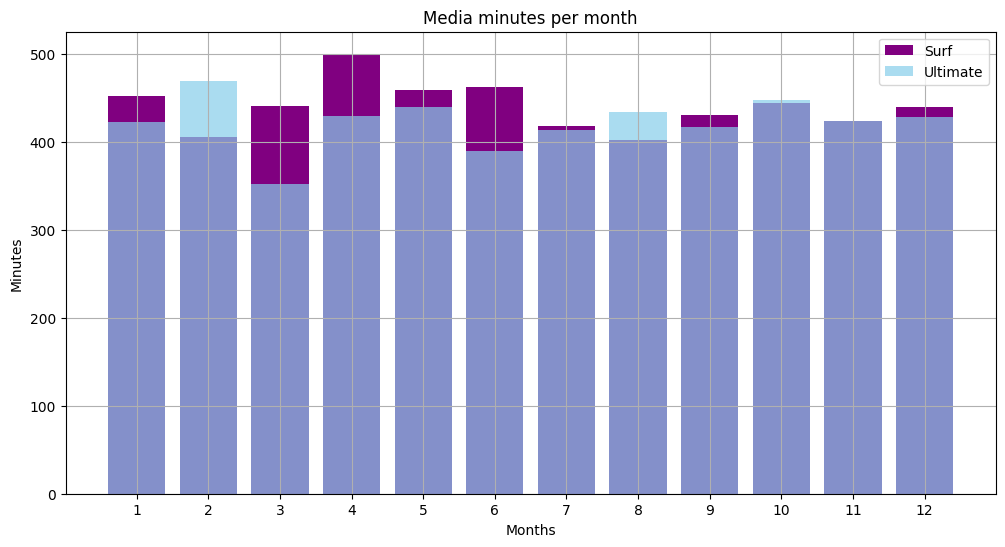

In [34]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
# y promedio de tiempo, x mes, montamos dos graficas en una para cada tipo de plan. 
surf_time= users_behavior[(users_behavior['plan']=='surf')][['month','total_minutes']].groupby('month').agg('mean').reset_index()
ultimate_time= users_behavior[(users_behavior['plan']=='ultimate')][['month','total_minutes']].groupby('month').agg('mean').reset_index()
plt.figure(figsize=[12,6])
plt.bar(surf_time['month'], surf_time['total_minutes'], color='purple', label='Surf')
plt.bar(ultimate_time['month'], ultimate_time['total_minutes'], color='skyblue', label='Ultimate', alpha=0.7)
plt.title('Media minutes per month')
plt.xlabel('Months')
plt.ylabel('Minutes')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.legend(['Surf', 'Ultimate'])
plt.grid(True)
plt.show()

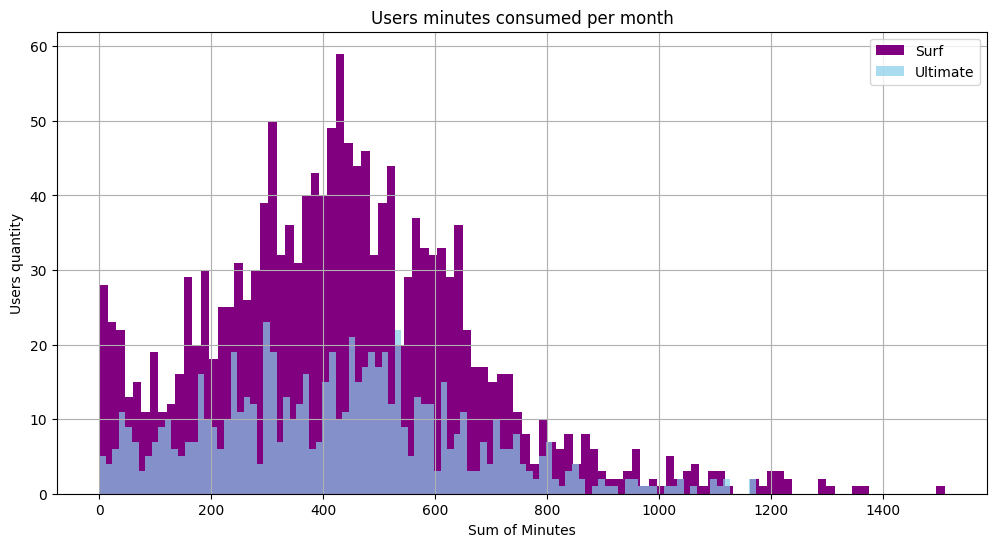

In [35]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
users_S_mth_time = users_behavior[(users_behavior['plan']=='surf')][['user_id','month','total_minutes']].groupby(['user_id','month']).agg('sum')
users_U_mth_time = users_behavior[(users_behavior['plan']=='ultimate')][['user_id','month','total_minutes']].groupby(['user_id','month']).agg('sum')
plt.figure(figsize=[12,6])
plt.hist(users_S_mth_time['total_minutes'], color='purple', bins=100)
plt.hist(users_U_mth_time['total_minutes'], color='skyblue', alpha=0.7, bins=100)
plt.title('Users minutes consumed per month')
plt.ylabel('Users quantity')
plt.xlabel('Sum of Minutes')
plt.legend(['Surf', 'Ultimate'])
plt.grid(True)
plt.show()

In [36]:
# Calcula la media y la varianza de la duración mensual de llamadas.
user_duration_per_call = users_behavior[['user_id','plan']].merge(calls).drop(columns='call_date')

user_U_call = user_duration_per_call[user_duration_per_call['plan']=='ultimate']['duration']
user_S_call = user_duration_per_call[user_duration_per_call['plan']=='surf']['duration']
user_u_call_var = np.var(user_U_call)
user_u_call_media = user_U_call.mean()
user_s_call_var = np.var(user_S_call)
user_s_call_media = user_S_call.mean()
print('La media de duración de llamadas para el plan Surf de forma mensual es: ', user_s_call_media, 'y su varianza es: ', user_s_call_var)
print()
print('La media de duración de llamadas para el plan Ultimate de forma mensual es: ', user_u_call_media, 'y su varianza es: ', user_u_call_var)

La media de duración de llamadas para el plan Surf de forma mensual es:  7.1701158701792815 y su varianza es:  35.472095031506605

La media de duración de llamadas para el plan Ultimate de forma mensual es:  7.099797268197718 y su varianza es:  35.35897386987289


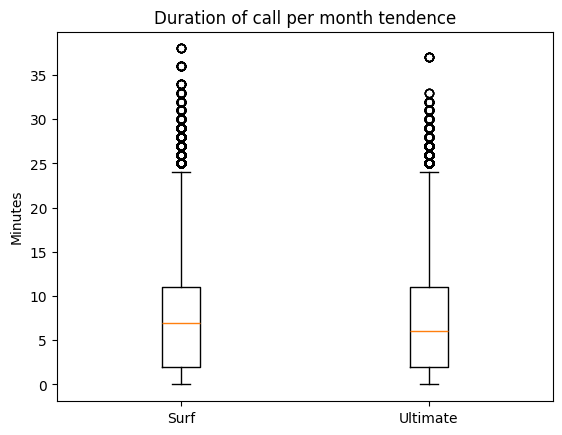

In [37]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
plt.boxplot([user_S_call, user_U_call], labels=['Surf','Ultimate'])
plt.title('Duration of call per month tendence')
plt.ylabel('Minutes')
plt.show()


Si bien, la densidad de usuarios que tienen el plan Surf es mayor a los que tienen el plan Ultimate, parece ser que sus llamadas tienen, en promedio mensual, la misma duracion por llamada individual. Así como una media mensual de consumo de minutos muy parecida también, esto da paso a la siguiente pregunta ¿Los usuarios del plan Surf, gastan más dinero por minutos ó los usuarios del plan Ultimate desaprovechan mucho sus minutos mensuales? 

### Mensajes

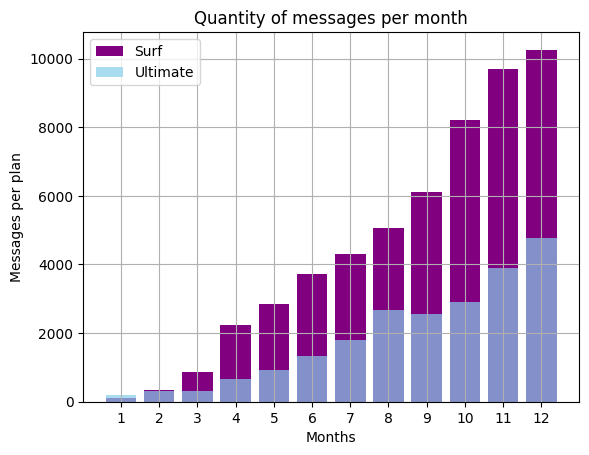

In [38]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
us_pl = users[['user_id','plan']]
surf_qty_message = users_behavior[users_behavior['plan']=='surf'][['qtty_messages','month']].groupby('month').agg('sum').reset_index()
ult_qty_message = users_behavior[users_behavior['plan']=='ultimate'][['qtty_messages','month']].groupby('month').agg('sum').reset_index()

plt.bar(surf_qty_message['month'], surf_qty_message['qtty_messages'], color='purple')
plt.bar(ult_qty_message['month'], ult_qty_message['qtty_messages'], color='skyblue', alpha=0.7)
plt.title('Quantity of messages per month')
plt.xlabel('Months')
plt.ylabel('Messages per plan')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.legend(['Surf', 'Ultimate'])
plt.grid(True)
plt.show()

In [39]:
user_message_month = users_behavior[['user_id','plan', 'qtty_messages']].merge(messages).drop(columns='message_date')

user_U_messag = user_message_month[user_message_month['plan']=='ultimate']['qtty_messages']
user_S_messag = user_message_month[user_message_month['plan']=='surf']['qtty_messages']
user_u_mes_var = np.var(user_U_messag)
user_u_mes_media = user_U_messag.mean()
user_s_mes_var = np.var(user_S_messag)
user_s_mes_media = user_S_messag.mean()
print('La media de mensajes para el plan Surf de forma mensual es: ', user_s_mes_media, 'y su varianza es: ', user_s_mes_var)
print()
print('La media de mensajes para el plan Ultimate de forma mensual es: ', user_u_mes_media, 'y su varianza es: ', user_u_mes_var)

La media de mensajes para el plan Surf de forma mensual es:  37.0031609859557 y su varianza es:  1200.1662510716183

La media de mensajes para el plan Ultimate de forma mensual es:  36.83990544624901 y su varianza es:  1294.9958795361665


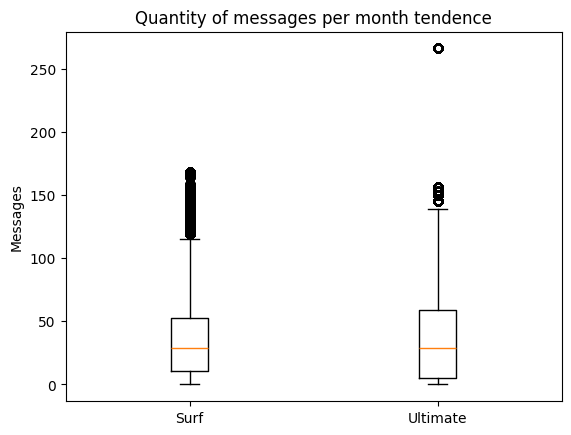

In [40]:
plt.boxplot([user_S_messag, user_U_messag], labels=['Surf','Ultimate'])
plt.title('Quantity of messages per month tendence')
plt.ylabel('Messages')
plt.show()

Para la cantidad de mensajes enviadas mensualmente y dependiendo del plan, se presentan comportamientos muy similares con una tendencia al aumento de actividad y envío de mensajes conforme pasa el tiempo, sorpresivamente el los usuarios del plan Surf tienden a enviar una mayor cantidad de mensajes frente a los usuarios del plan Ultimate. Para ambos la media de mensajes mensuales está al rededor de los 37 mensajes, sin embargo, la varianza entre un plan y otro varia en 94 unidaes, siendo el plan Ultimate el que tiene mayor varianza entre sus datos. 

### Internet

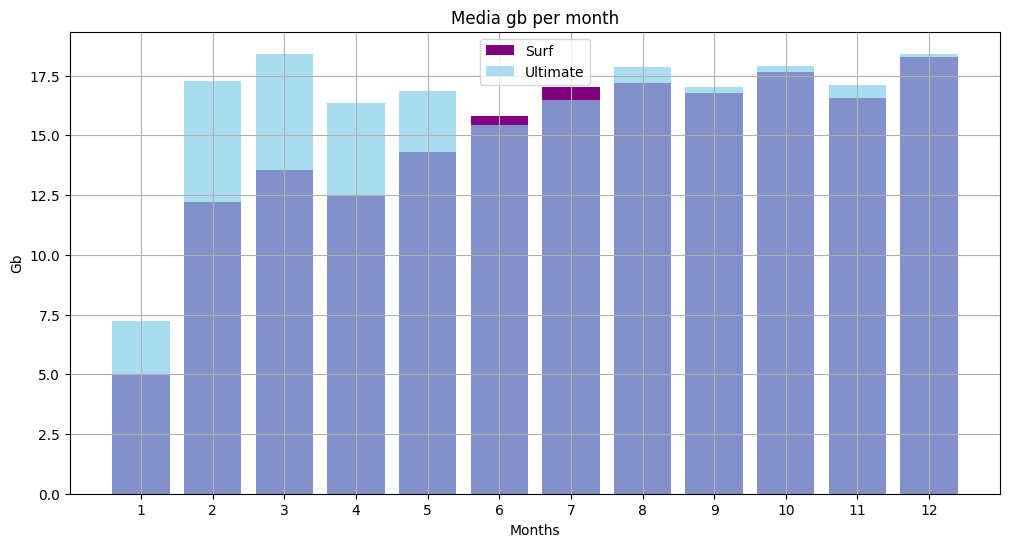

In [41]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
surf_gb= users_behavior[(users_behavior['plan']=='surf')][['month','gb_per_month']].groupby('month').agg('mean').reset_index()
ultimate_gb= users_behavior[(users_behavior['plan']=='ultimate')][['month','gb_per_month']].groupby('month').agg('mean').reset_index()

plt.figure(figsize=[12,6])
plt.bar(surf_gb['month'], surf_gb['gb_per_month'], color='purple', label='Surf')
plt.bar(ultimate_gb['month'], ultimate_gb['gb_per_month'], color='skyblue', label='Ultimate', alpha=0.7)
plt.title('Media gb per month')
plt.xlabel('Months')
plt.ylabel('Gb')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.legend(['Surf', 'Ultimate'])
plt.grid(True)
plt.show()


In [42]:
user_gb_month = users_behavior[['user_id','plan', 'gb_per_month']].merge(internet).drop(columns='session_date')

user_U_gb = user_gb_month[user_gb_month['plan']=='ultimate']['gb_per_month']
user_S_gb = user_gb_month[user_gb_month['plan']=='surf']['gb_per_month']
user_u_gb_var = np.var(user_U_gb)
user_u_gb_media = user_U_gb.mean()
user_s_gb_var = np.var(user_S_gb)
user_s_gb_media = user_S_gb.mean()
print('La media de gb para el plan Surf de forma mensual es: ', user_s_gb_media, 'y su varianza es: ', user_s_gb_var)
print()
print('La media de gb para el plan Ultimate de forma mensual es: ', user_u_gb_media, 'y su varianza es: ', user_u_gb_var)

La media de gb para el plan Surf de forma mensual es:  18.27939048249579 y su varianza es:  52.80040455996968

La media de gb para el plan Ultimate de forma mensual es:  19.023735517235167 y su varianza es:  61.67069363010473


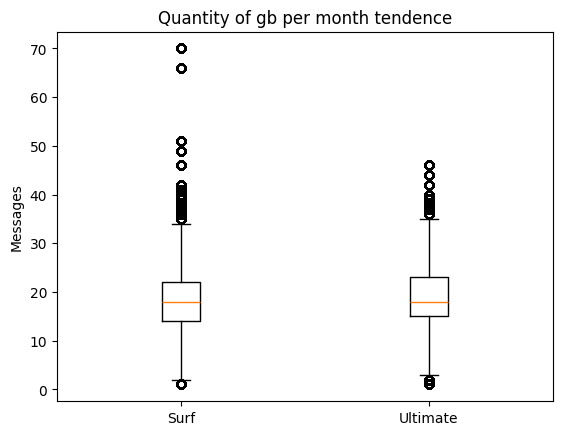

In [43]:
plt.boxplot([user_S_gb, user_U_gb], labels=['Surf','Ultimate'])
plt.title('Quantity of gb per month tendence')
plt.ylabel('Messages')
plt.show()

El consumo de internet es bastante parecido entre los dos planes, sin embargo, los usuarios del plan Ultimate presentan un mayor consumo de esta prestación de su plan, presentan un mayor promedio mensual, superando al consumo de los usuarios del plan Surf en casi todos los meses del año.

## Ingreso

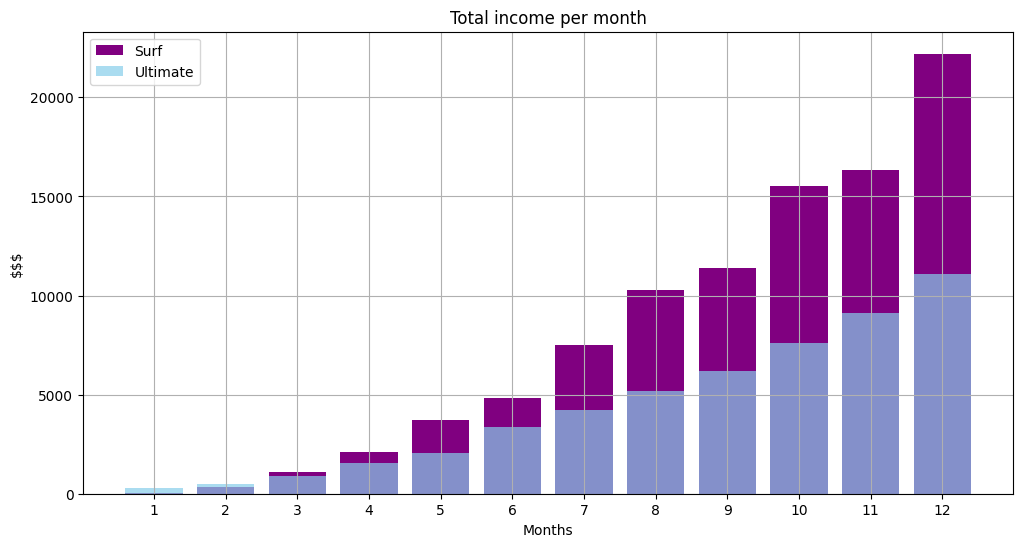

In [44]:
surf_inc= users_behavior[(users_behavior['plan']=='surf')][['month','total_per_month']].groupby('month').agg('sum').reset_index()
ultimate_inc= users_behavior[(users_behavior['plan']=='ultimate')][['month','total_per_month']].groupby('month').agg('sum').reset_index()
plt.figure(figsize=[12,6])
plt.bar(surf_inc['month'], surf_inc['total_per_month'], color='purple', label='Surf')
plt.bar(ultimate_inc['month'], ultimate_inc['total_per_month'], color='skyblue', label='Ultimate', alpha=0.7)
plt.title('Total income per month')
plt.xlabel('Months')
plt.ylabel('$$$')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.legend(['Surf', 'Ultimate'])
plt.grid(True)
plt.show()

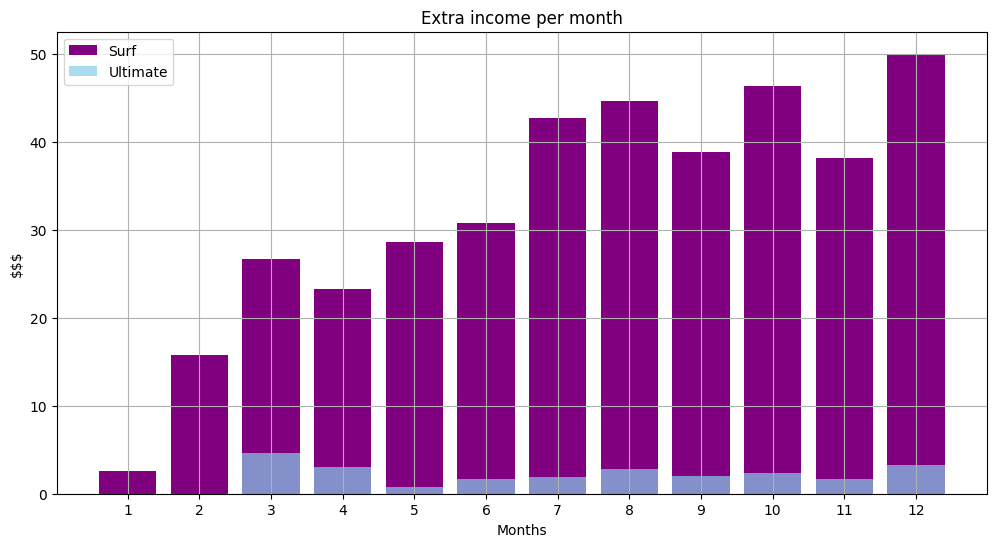

In [45]:
surf_einc= users_behavior[(users_behavior['plan']=='surf')][['month','total_extras']].groupby('month').agg('mean').reset_index()
ultimate_einc= users_behavior[(users_behavior['plan']=='ultimate')][['month','total_extras']].groupby('month').agg('mean').reset_index()
plt.figure(figsize=[12,6])
plt.bar(surf_einc['month'], surf_einc['total_extras'], color='purple', label='Surf')
plt.bar(ultimate_einc['month'], ultimate_einc['total_extras'], color='skyblue', label='Ultimate', alpha=0.7)
plt.title('Extra income per month')
plt.xlabel('Months')
plt.ylabel('$$$')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.legend(['Surf', 'Ultimate'])
plt.grid(True)
plt.show()

In [46]:
user_income_month = users_behavior[['user_id','plan', 'month', 'total_per_month']]

user_U_inc = user_income_month[user_income_month['plan']=='ultimate']['total_per_month']
user_S_inc = user_income_month[user_income_month['plan']=='surf']['total_per_month']
user_u_inc_var = np.var(user_U_inc)
user_u_inc_media = user_U_inc.mean()
user_s_inc_var = np.var(user_S_inc)
user_s_inc_media = user_S_inc.mean()
users_s_total_year = user_income_month[user_income_month['plan']=='surf']['total_per_month'].sum()
users_u_total_year = user_income_month[user_income_month['plan']=='ultimate']['total_per_month'].sum()
print('La media de ingresos generados para el plan Surf de forma mensual es: ', user_s_gb_media, 'y su varianza es: ', user_s_gb_var)
print('Los ingresos totales del año del plan Surf son: $', users_s_total_year)

print()
print('La media de ingresos generados para el plan Ultimate de forma mensual es: ', user_u_gb_media, 'y su varianza es: ', user_u_gb_var)
print('Los ingresos totales del año del plan Ultimate son: $', users_u_total_year)

La media de ingresos generados para el plan Surf de forma mensual es:  18.27939048249579 y su varianza es:  52.80040455996968
Los ingresos totales del año del plan Surf son: $ 95329.24

La media de ingresos generados para el plan Ultimate de forma mensual es:  19.023735517235167 y su varianza es:  61.67069363010473
Los ingresos totales del año del plan Ultimate son: $ 51996.0


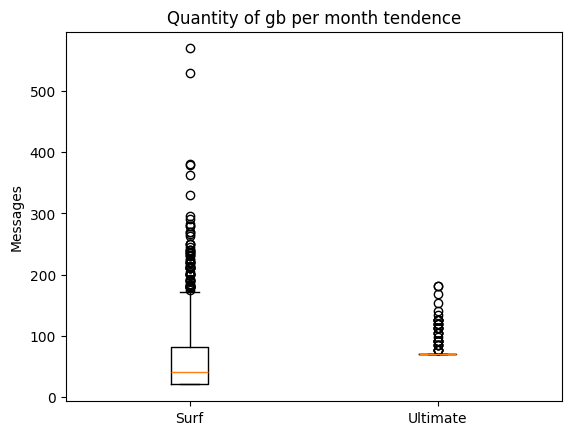

In [47]:
plt.boxplot([user_S_inc, user_U_inc], labels=['Surf','Ultimate'])
plt.title('Quantity of gb per month tendence')
plt.ylabel('Messages')
plt.show()

<div class="alert alert-block alert-success">
<b>Comentario revisor</b> <a class="tocSkip"></a>

 Muy buena prática la de usar distintos tipos de gráficas identificar algunos hallazgos y llegar a conclusiones
</div>

Si bien, los ingresos promedio mensuales tienen un mayor valor para el plan ultimate, es claramente evidente que los ingresos generados por el plan Surf son aplastantes frente a los ingresos generados por el plan Ultimate en el mismo año, y esto se debió a la gran cantidad generada por los costos extra para minutos, mensajes y gb consumidos fuera del plan de los usuarios de la tarifa Surf.

## Prueba las hipótesis estadísticas

In [48]:
# Prueba las hipótesis

a = 0.05
result_t, p_value = st.ttest_ind(user_S_inc, user_U_inc, equal_var=False)

print('Valor p del plan Surf: ', p_value)
if (p_value < a):
    print('Rechazamos la hipótesis nula')
else:
    print('No podemos rechazar la hipótesis nula')
print()


Valor p del plan Surf:  3.651467465471136e-14
Rechazamos la hipótesis nula



In [49]:
# Prueba las hipótesis
user_inc_city = user_income_month.merge(users[['user_id','city']]).drop(columns='plan')

n_YJ= ['NY', 'NJ']
mask = user_inc_city['city'].str.contains('|'.join(n_YJ))
users_NY_NJ = user_inc_city[mask]
users_oth_city = user_inc_city[~mask]



t, result_p = st.ttest_ind(users_NY_NJ['total_per_month'], users_oth_city['total_per_month'])
print('Valor p del plan Surf: ', result_p)
if (result_p < a):
    print('Rechazamos la hipótesis nula')
else:
    print('No podemos rechazar la hipótesis nula')


Valor p del plan Surf:  0.07662066734316698
No podemos rechazar la hipótesis nula


## Conclusión general

Dentro de este proyecto se analizaron muchs cosas: 
    1.- La cantidad de minutos y llamadas que cada plan ejecuta, mostrando que si bien los promedios tienden a ser similares, la densidad de llamadas son mayores para el plan Surf.
    2.- La cantidad de mensajes enviados por los usuarios de los distintos planes, en este punto también se mostró una abrumadora diferencia donde los usuarios del plan Surf mostraron hacer mayor uso de los SMS que los usuarios del plan Ultimate. 
    3.- El consumo de internet, si bien podría mostrarse como la caracteristica más pareja en el consumo entre los usuarios de ambos planes, fue la única característica de los planes en la que los usuarios del plan Ultimate superó el consumo de los del plan Surf.
    4.- Los ingresos que cada plan genera, si bien la media de ambos planes es casi igual, en el año del cual se nos proporcionó la información, se ve una clara diferencia entre el los ingresos generados por el plan Surf frente al plan Ultimate, generando esta enorme diferencia por el consumo extra y el costo de los mismos. 
    5.- La primera hipótesis nula fue rechazada, pues con los datos que se obtuvieron fueron suficientes para validar que la media de los ingresos generados por cada plan es diferente, para la segunda hipótesis no sucedió así, es posible que la cantidad de información que se tiene no nos dé lo suficiente para poder rechazar esta hipótesis.
